# Aufgabe 3

## 3.1 Fossile Erzeugung

Es wird der kostenminimale Einsatz der Kraftwerke sowie die Gesamtkosten der Stromversorgung und die THG Emissionen berechnet. Die Zielfunktion ergibt sich zu: <br>
$$ min \sum P_{KKt}\ MC_{KK} + P_{GuDt} \ MC_{GuD} + P_{Gt} \ MC_{G} $$
mit $P$ als Leistung und $MC$ den Grenzkosten der jeweiligen Kraftwerke. 

In [1]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

T = 24
timesteps = np.arange(T)

c_CO2 = 7 # EUR/tCO2

# Marginal costs der thermischen Kraftwerke berechnen
thermalPlant = ['Kohle', 'GuD', 'Gasturbine']
power = {'Kohle': 600,
         'GuD': 400,
         'Gasturbine': 300} # MW
efficiency = {'Kohle': 0.41,
         'GuD': 0.58,
         'Gasturbine': 0.4} 
fuel_price = {'Kohle': 10,
         'GuD': 25,
         'Gasturbine': 25} # EUR/MWhprim
emission_factor = {'Kohle': 0.35,
         'GuD': 0.2,
         'Gasturbine': 0.2} # tCO2/MWhprim
MC = {} # marginal costs in EUR/MWh
emissions = {} # emissions in tCO2/MWh
for n in thermalPlant:
    MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]
    emissions[n] = emission_factor[n] / efficiency[n]
    
# Daten laden
df = pd.read_excel('Last_PV_Wind.xlsx')
load = df['Last Sommer [MW]'] # hier nach Gruppennummer Sommer/Winter eingeben
wind = df['Wind 300 MW']
PV_100 = df['PV 100 MW Sommer']

# Speicher
Q_turb = 200 # MW
Q_pump = 200 # MW
SOC_max = 600 # MWh
SOCstart = 0 # MWh
eta_turb = 0.9 
eta_pump = 0.9 


In [2]:
# Pyomo Modell aufstellen

model = pyo.ConcreteModel()

model.x = pyo.Var(thermalPlant, timesteps, within=pyo.NonNegativeReals)
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# Zielfunktion
def zielfunktion(model):
    return sum(model.x[n, t] * MC[n] for n in thermalPlant for t in timesteps)
               
model.obj = pyo.Objective(rule=zielfunktion, 
                          sense=pyo.minimize)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = pyo.Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load.loc[t]
model.load_con = pyo.Constraint(timesteps, 
                            rule = load_constraint_rule)

opt = pyo.SolverFactory('gurobi')
opt_success = opt.solve(model)

#model.display()

# get values of optimization variables
PowerThermal = pd.DataFrame(index = timesteps, columns = thermalPlant)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n,t].value

b) Graphische Darstellung:

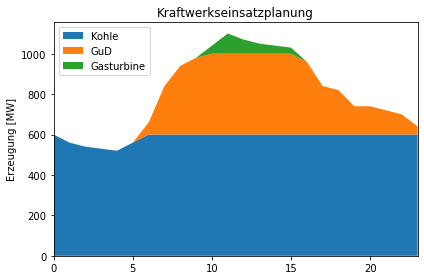

Die Gesamtkosten der Stromversorgung belaufen sich auf:  667814.61  €
Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen 13858.40 t CO2


In [3]:
# plo
fig, ax = plt.subplots()
ax.stackplot(timesteps, 
             PowerThermal.to_numpy(dtype = float).transpose(), 
             labels=thermalPlant)
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='upper left')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()
plt.show()
print(f"Die Gesamtkosten der Stromversorgung belaufen sich auf:  {model.obj():.2f}  €")
# Emisionen:
GesamtEmissionen = sum(emissions[n] * model.x[n, t].value for t in timesteps for n in thermalPlant)
print(f"Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen {GesamtEmissionen:.2f} t CO2")

c) **Interpretation der Schattenvariable**

Im nächsten Schritt sollen die stündlichen Werte der Schattenvariable der Beschränkung der Lastdeckung angegeben werden. Diese Schattenvariable kann interpretiert werden als die maximalen Grenzkosten an, mit der ein Kraftwerk verwendet werden darf.  Diese Kosten geben zur jeweiligen Tagesstunde den "Market Clearing Price", also die Grenzkosten des preissetzenden Kraftwerkes an. 

In [4]:
DualSystem = pd.DataFrame(index = timesteps, columns = ['Schattenvariable'])
for t in range(24):
    DualSystem.loc[t,'Schattenvariable'] = float(model.dual[model.load_con[t]])
DualSystem['load'] = load
DualSystem

,Schattenvariable,load
0,30.3659,600
1,30.3659,560
2,30.3659,540
3,30.3659,530
4,30.3659,520
5,30.3659,560
6,45.5172,660
7,45.5172,840
8,45.5172,940
9,45.5172,980


d) Der stündliche Strompreis unter optimalem Wetbewerb ergibt sich aus den Grenzkosten:


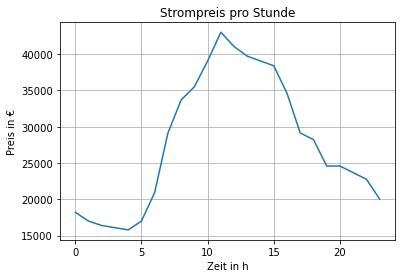

In [5]:
strompreis_pro_stunde = []
for i in timesteps:
    preis = sum(PowerThermal.loc[i, n] * MC[n] for n in thermalPlant)
    strompreis_pro_stunde.append(preis)

# plot
plt.plot(timesteps, strompreis_pro_stunde)
plt.title("Strompreis pro Stunde")
plt.ylabel("Preis in €")
plt.xlabel("Zeit in h")
plt.grid()

## 3.2 Erneuerbare Erzeugung

a) Bei der Erneuerbaren Erzeugung muss der Erneurbare Strom immer abgenommen werden. Darum wird er in diesem Beispiel gleich zu Anfang von der Last abgezogen. Zielfunktion und Nebenbedingungen bleiben ident zu 3.1.

In [6]:
# Erneurbare müssen abgenommen werden: load - wind - PV 100 c
load_new = load - wind - PV_100 
load_new[load_new < 0] = 0
model = pyo.ConcreteModel()

model.x = pyo.Var(thermalPlant, timesteps, within=pyo.NonNegativeReals)
#model.schattenvar = pyo.Suffix()

# Zielfunktion
def zielfunktion(model):
    return sum(model.x[n, t] * MC[n] for n in thermalPlant for t in timesteps)
               
model.obj = pyo.Objective(rule=zielfunktion, 
                          sense=pyo.minimize)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = pyo.Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load_new.loc[t]
model.load_con = pyo.Constraint(timesteps, 
                            rule = load_constraint_rule)

opt = pyo.SolverFactory('gurobi')
opt_success = opt.solve(model, report_timing=True)

#model.display()

        0.01 seconds required to write file
        0.01 seconds required for presolve
        0.23 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds required to read solution file 
        0.01 seconds required for postsolve


b)

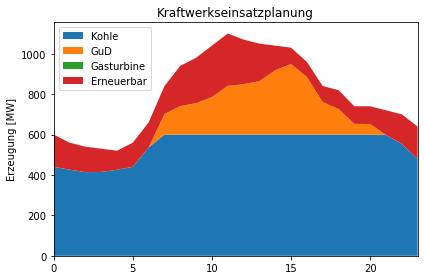

Die Gesamtkosten der Stromversorgung belaufen sich auf: 520704.52 €
Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen 12132.18 t CO2


In [7]:
# get values of optimization variables
PowerThermalandRenewable = pd.DataFrame(index = timesteps, 
                                        columns = ['Kohle', 
                                                   'GuD', 
                                                   'Gasturbine', 
                                                   'Erneuerbar']
                                        )
for t in timesteps:
    PowerThermalandRenewable.loc[t, 'Erneuerbar'] = wind[t] + PV_100[t] 
    for n in thermalPlant:
        PowerThermalandRenewable.loc[t, n] = model.x[n,t].value

fig, ax = plt.subplots()
ax.stackplot(timesteps, 
              PowerThermalandRenewable.to_numpy(dtype = float).transpose(), 
              labels=['Kohle', 'GuD', 'Gasturbine', 'Erneuerbar'])
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='upper left')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()
plt.show()
print("Die Gesamtkosten der Stromversorgung belaufen sich auf: " + str(round(model.obj(), 2)) + " €")
# Emisionen:
GesamtEmissionen = sum(emissions[n] * model.x[n, t].value for t in timesteps for n in thermalPlant)
print("Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen "+str(round(GesamtEmissionen,2))+" t CO2")

c)

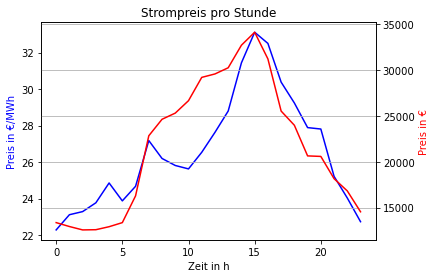

In [8]:
strompreis_pro_stunde = []
for i in timesteps:
    preis = sum(PowerThermalandRenewable.loc[i, n] * MC[n] for n in thermalPlant)
    strompreis_pro_stunde.append(preis)

# plot
fig = plt.figure()
ax = plt.gca()
ax2 = ax.twinx()
ax.plot(timesteps, strompreis_pro_stunde/load, color="blue")
ax.set_title("Strompreis pro Stunde")
ax.set_ylabel("Preis in €/MWh")
ax2.plot(timesteps, strompreis_pro_stunde, color="red")
ax2.set_ylabel("Preis in €")
ax.set_xlabel("Zeit in h")
ax.yaxis.label.set_color('blue')
ax2.yaxis.label.set_color('red')
plt.grid()

## 3.3 Speicher

In Aufgabe 3.3 sind wieder der kostenminimale Kraftwerkseinsatz sowie die Gesamtkosten und THG-Emissionen inklusive erneuerbarer Erzeugung und als neuen Aspekt inklusive der Speicher zu ermitteln und mathematisch darzustellen. Weiters sind die Emissionen im Vergleich zum Fall ohne Speicher sowie ohne EE zu analaysieren und die stündlichen Strompreise darzustellen. 

3.3 a)
Es werden der kostenminimale Kraftwerkseinsatz und die Gesamtkosten und THG-Emissionen inklusive erneuerbarer Erzeugung und Speicher dargestellt.
Wir haben angenommen, dass der Speicher am Anfang sowie am Ende der Periode leer ist.
Der kostenminimale Kraftwerkseinsatz wird unterhalb dargestellt.

In [9]:
# Speicher inkludiert, Erneuerbare müssen abgenommen werden: load - wind - PV 100 
load_new = load - wind - PV_100 
load_new[load_new < 0] = 0
model = pyo.ConcreteModel()

model.x = pyo.Var(thermalPlant, timesteps, within=pyo.NonNegativeReals)
model.q_turb = pyo.Var(timesteps, bounds = (0, Q_turb))
model.q_pump = pyo.Var(timesteps, bounds = (0, Q_pump))
model.SOC = pyo.Var(timesteps, bounds = (0, SOC_max))

#model.storage = pyo.Var(storage, timesteps)
#model.schattenvar = pyo.Suffix()

# Zielfunktion
def zielfunktion(model):
    return sum(model.x[n, t] * MC[n] for n in thermalPlant for t in timesteps)
               
model.obj = pyo.Objective(rule=zielfunktion, 
                          sense=pyo.minimize)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = pyo.Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == (load_new.loc[t] + model.q_pump[t] - model.q_turb[t])
model.load_con = pyo.Constraint(timesteps, 
                            rule = load_constraint_rule)

# q_turb
def qturb_constraint_rule(model, t):  
   return model.q_turb[t] <= model.SOC[t-1]

model.qturb_init_con = pyo.Constraint(
        expr = (model.q_turb[0] <= SOCstart))

model.qturb_con = pyo.Constraint(timesteps[1:], rule = qturb_constraint_rule)

# SOC
def SOC_constraint_rule(model, t):  
   return (model.SOC[t-1] 
           + model.q_pump[t]*eta_pump 
           - model.q_turb[t]/eta_turb 
           - model.SOC[t] == 0)

# Storage equation
model.SOC_init_con = pyo.Constraint(
        expr = (SOCstart 
                + model.q_pump[0]*eta_pump 
                - model.q_turb[0]/eta_turb 
                - model.SOC[0] == 0))

model.SOC_con = pyo.Constraint(timesteps[1:], 
                           rule = SOC_constraint_rule)

model.SOC_end_con = pyo.Constraint(
        expr = (model.SOC[T-1] == SOCstart))                           


opt = pyo.SolverFactory('gurobi')
opt_success = opt.solve(model, report_timing=True)

#model.display()

        0.01 seconds required to write file
        0.01 seconds required for presolve
        0.22 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds required to read solution file 
        0.01 seconds required for postsolve


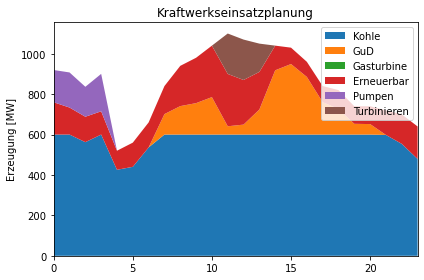

Die Gesamtkosten der Stromversorgung belaufen sich auf: 516369.12 €
Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen 12515.08 t CO2


In [10]:
# get values of optimization variables
PowerThermalandRenewableandStorage = pd.DataFrame(index = timesteps, 
                                        columns = ['Kohle', 
                                                   'GuD', 
                                                   'Gasturbine', 
                                                   'Erneuerbar',
                                                   'Pumpen',
                                                   'Turbinieren']
                                        )
for t in timesteps:
    PowerThermalandRenewableandStorage.loc[t, 'Erneuerbar'] = wind[t] + PV_100[t] 
    PowerThermalandRenewableandStorage.loc[t, 'Pumpen'] = model.q_pump[t].value
    PowerThermalandRenewableandStorage.loc[t, 'Turbinieren'] = model.q_turb[t].value
    for n in thermalPlant:
        PowerThermalandRenewableandStorage.loc[t, n] = model.x[n,t].value

fig, ax = plt.subplots()
ax.stackplot(timesteps, 
              PowerThermalandRenewableandStorage.to_numpy(dtype = float).transpose(), 
              labels=['Kohle', 'GuD', 'Gasturbine', 'Erneuerbar', 'Pumpen', 'Turbinieren'])
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='upper right')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()
plt.show()

print(f"Die Gesamtkosten der Stromversorgung belaufen sich auf: {model.obj():.2f} €")
# Emisionen:
GesamtEmissionen = sum(emissions[n] * model.x[n, t].value for t in timesteps for n in thermalPlant)
print(f"Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen {GesamtEmissionen:.2f} t CO2")

3.3 b) Das mathematische Modell inkl. Speicher sieht folgendermaßen aus: 

**Zielfunktion**

$minimize \ C = \sum \limits _{t=1} ^{24} P_{KKt}\ MC_{KK} + P_{GuDt} \ MC_{GuD} + P_{Gt} \ MC_{G}$

**Nebenbedingungen**

$ Last_{t} = P_{KKt} + P_{GuDt} + P_{Gt} + P_{Windt} + P_{PVt} - q_{pumpt} + q_{turbt}  \ für \ t = 0,1,...,23. $  

$ 0 \le P_{KKt} \le 600,$  
$ 0 \le P_{GuDt} \le 400,$  
$ 0 \le P_{Gt} \le 300,$  
$ 0 \le q \le 200,$   
$ 0 \le SOC_{t} \le 600 \ für  \ t = 0,1,...,23.$   

$ SOC_{0} = 0 \ and \ SOC_{24} = 0 $  

$ Q_{turbt} \le SOC_{t-1} \ für  \ t = 1,2,...,23.$ 

$ SOC_{t} = SOC_{t-1} + q_{pumpt} * \eta_{pump} - q_{turbt}/\eta_{turb} \ für  \ t = 1,2,...,23.$ 


Variablen:  
KK = Kohle  
GuD = Gas und Dampf  
G = Gas   
P = Leistung  
MC = kurzfristige Grenzkosten  
L = Last  
q = Leistung pumpen/turbinieren  
SOC = Speicherstand (state of charge)  
$\eta$ = Effizienz




3.3 c) Durch den Speicherbetrieb erhöhen sich die Gesamtemissionen. Da in unserem Modell lediglich hinischtlich der Kosten optimiert wird, wird die Stromerzeugung des Pumpspeicherkraftwerks in Stunden verlegt in denen sonst mit emissionsärmere GuD Kraftwerke erzeugt werden würden. Die Turbinierung erfolgt in Stunden in denen mit Kohle produziert wird.  
In der Realität müsste die Emissionskomponente im Modell berücksichtigt werden, da es nicht zielführend ist höhere Kohlekapazitäten in Anspruch zu nehmen. 

3.3 d) Die Änderung der stündlichen Strompreise ist in untenstehender Grafik dargestellt. 

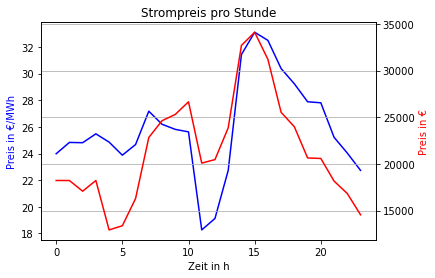

In [11]:
strompreis_pro_stunde = []
pump_last = []
for i in timesteps:
    preis = sum(PowerThermalandRenewableandStorage.loc[i, n] * MC[n] for n in thermalPlant)
    strompreis_pro_stunde.append(preis)
    pump_last.append(model.q_pump[i].value)

# plot
fig = plt.figure()
ax = plt.gca()
ax2 = ax.twinx()
ax.plot(timesteps, strompreis_pro_stunde/(load + pump_last), color="blue")
ax.set_title("Strompreis pro Stunde")
ax.set_ylabel("Preis in €/MWh")
ax2.plot(timesteps, strompreis_pro_stunde, color="red")
ax2.set_ylabel("Preis in €")
ax.set_xlabel("Zeit in h")
ax.yaxis.label.set_color('blue')
ax2.yaxis.label.set_color('red')
plt.grid()

3.3 e)

| Modell                | Gesamtkosten (€) | Gesamtemissionen (t CO2) |
|-----------------------|------------------|--------------------------|
| Fossile Erzeugung     | 667814.61        | 13858.4                  |
| Erneuerbare Erzeugung | 520704.52        | 12132.18                 |
| Inklusive Speicher    | 516369.12        | 12515.08                 |

Es ist zu sehen, dass die Gesamtkosten bei fossiler Erzeugung am höchsten sind. Durch die Integration von EE und Speicher können die Kosten gesenkt werden.
Hinsichtlich der Emissionen ist zu sehen, dass diese durch die Integration der EE sinken jedoch durch den Einsatz des Speichers aus den in 3.3 c genannten Gründen wieder steigen. 

## 3.4 Kosten vs. Emissionen

3.4 a)
Nun werden nicht mehr die Gesamtkosten minimiert, sondern die Gesamtemissionen. Dazu werden die obigen Modelle der thermalen und erneuerbaren Stromerzeugen ohne (1) und mit (2) Speicher betrachtet. Um eine minimierung der Gesamtemissionen zu erzielen muss dazu die Zielfunktion der Optimierungsmodelle geändert werden. Im ersten Schritt wurde die Minimierung der Gesamtemissionen für Punkt (1) durchgeführt. Die Ergebnisse für die Minimierung werden gleich anschließend gezeigt. 

In [12]:
# Erneurbare müssen abgenommen werden: load - wind - PV 100 
load_new = load - wind - PV_100 

model = pyo.ConcreteModel()

model.x = pyo.Var(thermalPlant, timesteps, within=pyo.NonNegativeReals)
#model.schattenvar = pyo.Suffix()

# Zielfunktion
def zielfunktion(model):
    return sum(model.x[n, t] * emissions[n] for n in thermalPlant for t in timesteps)
               
model.obj = pyo.Objective(rule=zielfunktion, 
                          sense=pyo.minimize)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = pyo.Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load_new.loc[t]
model.load_con = pyo.Constraint(timesteps, 
                            rule = load_constraint_rule)

opt = pyo.SolverFactory('gurobi')
opt_success = opt.solve(model, report_timing=True)

#model.display()

        0.01 seconds required to write file
        0.01 seconds required for presolve
        0.22 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds required to read solution file 
        0.01 seconds required for postsolve


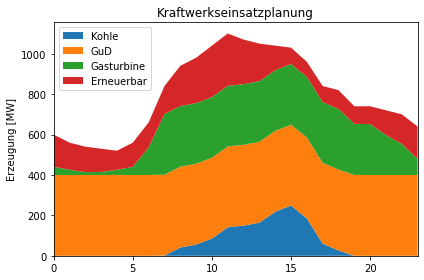

Die Gesamtkosten der Stromversorgung belaufen sich auf: 797793.51 €
Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen 6901.97 t CO2


In [13]:
# get values of optimization variables
PowerThermalandRenewable = pd.DataFrame(index = timesteps, 
                                        columns = ['Kohle', 
                                                   'GuD', 
                                                   'Gasturbine', 
                                                   'Erneuerbar']
                                        )
for t in timesteps:
    PowerThermalandRenewable.loc[t, 'Erneuerbar'] = wind[t] + PV_100[t] 
    for n in thermalPlant:
        PowerThermalandRenewable.loc[t, n] = model.x[n,t].value

fig, ax = plt.subplots()
ax.stackplot(timesteps, 
              PowerThermalandRenewable.to_numpy(dtype = float).transpose(), 
              labels=['Kohle', 'GuD', 'Gasturbine', 'Erneuerbar'])
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='upper left')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()
plt.show()
# Gesamtkosten
GesamtKosten = sum(model.x[n,t].value * MC[n] for t in timesteps for n in thermalPlant)
print("Die Gesamtkosten der Stromversorgung belaufen sich auf: " + str(round(GesamtKosten, 2)) + " €")
# Emissionen:
GesamtEmissionen = sum(emissions[n] * model.x[n, t].value for t in timesteps for n in thermalPlant)
print("Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen "+str(round(GesamtEmissionen,2))+" t CO2")

In dem obigen Plot erkennt man, dass sich der Anteil an Kohle an der Energieerzeugung im Verlgeich zur Minimierung der Gesamtkosten stark zurückgegangen ist. Dies ist ein logischer Schluss, da Kohle eine Form der günstigen Energieerzeugung darstellt, jedoch den höchsten Austoß an THG verzeichnet.Einen großen Anteil der Energiegewinnung stellt ein Gud-Kraftwerk dar. Dieses erzielt bei einer höhren Leistung einen besseren Wirkungsgrad als die Gasturbine bei gleichbleibendem THG Austoß pro Energieeinheit. Die Gesamtkosten der Stromversorgung stellen hierbei den höchsten Anteil dar, da die Erzeugung von Strom durch GuD und Gasturbine wesentlich teuerer ist, als mit einem Kohlekraftwerk. 

Im nächsten Schritt wird das selbe Prozedere auf Punkt (2) durchgeführt: 

In [14]:
# Speicher inkludiert, Erneuerbare müssen abgenommen werden: load - wind - PV 100 
load_new = load - wind - PV_100 

model = pyo.ConcreteModel()

model.x = pyo.Var(thermalPlant, timesteps, within=pyo.NonNegativeReals)
model.q_turb = pyo.Var(timesteps, bounds = (0, Q_turb))
model.q_pump = pyo.Var(timesteps, bounds = (0, Q_pump))
model.SOC = pyo.Var(timesteps, bounds = (0, SOC_max))

#model.storage = pyo.Var(storage, timesteps)
#model.schattenvar = pyo.Suffix()

# Zielfunktion
def zielfunktion(model):
    return sum(model.x[n, t] * emissions[n] for n in thermalPlant for t in timesteps)
               
model.obj = pyo.Objective(rule=zielfunktion, 
                          sense=pyo.minimize)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = pyo.Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == (load_new.loc[t] + model.q_pump[t] - model.q_turb[t])
model.load_con = pyo.Constraint(timesteps, 
                            rule = load_constraint_rule)

# q_turb
def qturb_constraint_rule(model, t):  
   return model.q_turb[t] <= model.SOC[t-1]

model.qturb_init_con = pyo.Constraint(
        expr = (model.q_turb[0] <= SOCstart))

model.qturb_con = pyo.Constraint(timesteps[1:], rule = qturb_constraint_rule)

# SOC
def SOC_constraint_rule(model, t):  
   return (model.SOC[t-1] 
           + model.q_pump[t]*eta_pump 
           - model.q_turb[t]/eta_turb 
           - model.SOC[t] == 0)

# Storage equation
model.SOC_init_con = pyo.Constraint(
        expr = (SOCstart 
                + model.q_pump[0]*eta_pump 
                - model.q_turb[0]/eta_turb 
                - model.SOC[0] == 0))

model.SOC_con = pyo.Constraint(timesteps[1:], 
                           rule = SOC_constraint_rule)

model.SOC_end_con = pyo.Constraint(
        expr = (model.SOC[T-1] == SOCstart))                           


opt = pyo.SolverFactory('gurobi')
opt_success = opt.solve(model, report_timing=False)

#model.display()


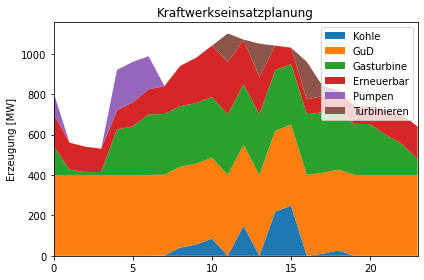

Die Gesamtkosten der Stromversorgung belaufen sich auf: 825395.95 €
Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen 6774.33 t CO2


In [15]:
# get values of optimization variables
PowerThermalandRenewableandStorage = pd.DataFrame(index = timesteps, 
                                        columns = ['Kohle', 
                                                   'GuD', 
                                                   'Gasturbine', 
                                                   'Erneuerbar',
                                                   'Pumpen',
                                                   'Turbinieren']
                                        )
for t in timesteps:
    PowerThermalandRenewableandStorage.loc[t, 'Erneuerbar'] = wind[t] + PV_100[t] 
    PowerThermalandRenewableandStorage.loc[t, 'Pumpen'] = model.q_pump[t].value
    PowerThermalandRenewableandStorage.loc[t, 'Turbinieren'] = model.q_turb[t].value
    for n in thermalPlant:
        PowerThermalandRenewableandStorage.loc[t, n] = model.x[n,t].value

fig, ax = plt.subplots()
ax.stackplot(timesteps, 
              PowerThermalandRenewableandStorage.to_numpy(dtype = float).transpose(), 
              labels=['Kohle', 'GuD', 'Gasturbine', 'Erneuerbar', 'Pumpen', 'Turbinieren'])
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='upper right')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()
plt.show()

# Gesamtkosten
GesamtKosten = sum(model.x[n,t].value * MC[n] for t in timesteps for n in thermalPlant)
print("Die Gesamtkosten der Stromversorgung belaufen sich auf: " + str(round(GesamtKosten, 2)) + " €")
# Emissionen:
GesamtEmissionen = sum(emissions[n] * model.x[n, t].value for t in timesteps for n in thermalPlant)
print("Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen "+str(round(GesamtEmissionen,2))+" t CO2")

Ebenso wie im vorherige Beispiel ist der Anteil der Energieerzeugung durch Kohle wesentlich geringer als bei den Kostenminimierungsbeispielen. In folgender Tabelle sind die Ergebnisse der beiden Modelle nocheinmal gegenübergestellt. 

| Modell                | Gesamtkosten (€) | Gesamtemissionen (t CO2) |
|-----------------------|------------------|--------------------------|
| Erneuerbare Erzeugung exkl. Speicher     | 797793.51        | 6901.97                  |
| Erneuerbare Erzeugung inkl. Speicher | 825394.95        | 6774.33                 |


Dabei erkennt man, dass die Gesamtkosten in einem Stromsystem mit einem Speicher höher sind als ohne. Dies liegt an der zusätzlichen Belastung durch die Pumpen. Um diese zu betreiben, muss zusätzlich eine Gasturbine zugeschaltet werden. Die Gesamtemissionen werden dabei geringer, da in Zeiten in denen der Strombedarf übersteigt, kann mit dem turbinieren des Speichers Kohle eingespart werden. Daraus ergeben sich die geringeren Emissionswerte als bei der Erzeugung ohne Speicher. 

3.4 c)

Im nächsten Schritt soll nun die Auswirkung des $CO_2$ Preises auf beide Modelle (Erneuerbare Erzeugung mit und ohne Stromspeicher) unter dem Blickwinkel der Kostenoptimierung untersucht werden. Dabei wird zuerst ausgegangen von einem Preis von 0 $EUR/tCO_2$ und dieser sukzessiv gesteigert.

In [16]:
GesamtKosten = []
GesamtEmissionen = []
c_CO2_index = []
for c_CO2 in range(0,250,5): 

    for n in thermalPlant:
        MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]

    model = pyo.ConcreteModel()

    model.x = pyo.Var(thermalPlant, timesteps, within=pyo.NonNegativeReals)
    model.q_turb = pyo.Var(timesteps, bounds = (0, Q_turb))
    model.q_pump = pyo.Var(timesteps, bounds = (0, Q_pump))
    model.SOC = pyo.Var(timesteps, bounds = (0, SOC_max))

    # Zielfunktion
    def zielfunktion(model):
        return sum(model.x[n, t] * MC[n] for n in thermalPlant for t in timesteps)

    model.obj = pyo.Objective(rule=zielfunktion, 
                              sense=pyo.minimize)

    def power_constraint_rule(model, n, t):    
       return model.x[n,t] <= power[n]
    model.power_con = pyo.Constraint(thermalPlant, 
                                 timesteps, 
                                 rule = power_constraint_rule)

    def load_constraint_rule(model, t):    
       return sum(model.x[n,t] for n in thermalPlant) == (load_new.loc[t] + model.q_pump[t] - model.q_turb[t])
    model.load_con = pyo.Constraint(timesteps, 
                                rule = load_constraint_rule)

    # q_turb
    def qturb_constraint_rule(model, t):  
       return model.q_turb[t] <= model.SOC[t-1]

    model.qturb_init_con = pyo.Constraint(
            expr = (model.q_turb[0] <= SOCstart))

    model.qturb_con = pyo.Constraint(timesteps[1:], rule = qturb_constraint_rule)

    # SOC
    def SOC_constraint_rule(model, t):  
       return (model.SOC[t-1] 
               + model.q_pump[t]*eta_pump 
               - model.q_turb[t]/eta_turb 
               - model.SOC[t] == 0)

    # Storage equation
    model.SOC_init_con = pyo.Constraint(
            expr = (SOCstart 
                    + model.q_pump[0]*eta_pump 
                    - model.q_turb[0]/eta_turb 
                    - model.SOC[0] == 0))

    model.SOC_con = pyo.Constraint(timesteps[1:], 
                               rule = SOC_constraint_rule)

    model.SOC_end_con = pyo.Constraint(
            expr = (model.SOC[T-1] == SOCstart))                           


    opt = pyo.SolverFactory('gurobi')
    opt_success = opt.solve(model, report_timing=False)
    
    GesamtKosten_i = sum(model.x[n,t].value * MC[n] for t in timesteps for n in thermalPlant)
    GesamtEmissionen_i = sum(emissions[n] * model.x[n, t].value for t in timesteps for n in thermalPlant)
    GesamtKosten.append(GesamtKosten_i)
    GesamtEmissionen.append(GesamtEmissionen_i)
    c_CO2_index.append(c_CO2)
#for i in range(len(c_CO2_index)): 
#    print('%i, %.2f, %.2f' % (c_CO2_index[i], GesamtKosten[i], GesamtEmissionen[i]))

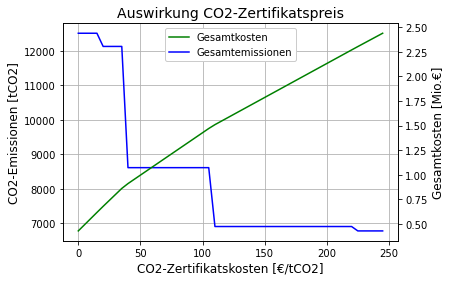

In [17]:
# show results
ax = plt.gca()
ax2 = ax.twinx()

lns1 = ax2.plot(c_CO2_index, [i/10**6 for i in GesamtKosten], 'g', linewidth = 1.5, label = 'Gesamtkosten')
lns2 = ax.plot(c_CO2_index, GesamtEmissionen, 'b',linewidth=1.5, label = 'Gesamtemissionen')

ax.set_ylabel("CO2-Emissionen [tCO2]",fontsize=12,color='black')
ax2.set_ylabel("Gesamtkosten [Mio.€]",fontsize=12,color='black')
ax.set_xlabel('CO2-Zertifikatskosten [€/tCO2]', fontsize=12, color='black')
plt.title("Auswirkung CO2-Zertifikatspreis", fontsize=14,color='black')
ax.grid(True)
# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=9, framealpha = 1)
#ax.set_yrange()
#ax.set_xrange()



plt.show()

#ax.set(xlabel='CO2-Zertifikatskosten in €/tCO2', ylabel='voltage (mV)',
#       title='About as simple as it gets, folks')

Der Plot zeigt, dass sich der CO2-Zertifikatspreis sprunghaft auf die Emissionen auswirkt. Der Grund hierfür liegt an der sinkenden Wirtschaftlichkeit der einzelenen Energieerzeuger. Bei einem Zertifikatspreis von ca 19€/tCO2 wird der Speicher unwirtschaftlich. Dieser wird dann nicht mehr verwendet und es kommt zur ersten Absenkung der Gesamt-emissionen. Bei 37€/tCO2 wird das GuD Kraftwerk auf höchster Leistung gefahren. Zur Deckung der Gesamtlast wird dann noch das Kohlekraftwerk verwendet. Folgende drei Plots veranschaulichen diese Szenarien, wobei im ersten Plot der Zertifikatspreis bei 18€/tCO2, im zweiten Plot bei 19€/tCO2 liegt und im dritten Plot bei 37€/tCO2. 

<img src="Aufgabe_3_4_bilder/CO2_Speicher_18.png" style="height: 300px;"/>
<img src="Aufgabe_3_4_bilder/CO2_Speicher_19.png" style="height: 300px;"/>
<img src="Aufgabe_3_4_bilder/CO2_37.png" style="height: 300px;"/>

Wenn nun der CO2-Zertifikatspreis auf $108$ €$/tCO2$ steigt, wird nun die Gasturbine wirtschaftlicher, das Kohlekraftwerk wird nur noch hinzugeschaltet, wenn die Deckung der Gesamtlast durch die anderen Energieträger nicht aufrecht erhalten werden kann.

<img src="Aufgabe_3_4_bilder/CO2_108.png" style="height: 300px;"/>

Der letzte Plot veranschaulicht, wenn der $CO_2$-Zertifikatspreis auf über $224$ € $/tCO_2$ steigt. In diesem Bereich wird der Speicher wieder wirtschaftlicher und der Betrieb des Kohlekraftwerks wird noch weiter eingeschränkt. 

<img src="Aufgabe_3_4_bilder/CO2_Speicher_224.png" style="height: 300px;"/>

3.4 d.)

Damit die THG-Emissionen so hoch sind wie in dem den Szenarien wo die Gesamtemissionen minimiert werden (ohne Speicher), muss der Zertifikatspreis mindestens $108$ €$/tCO_2$ ausmachen. Damit erreicht man eine Gesamtemission von $6901.97$ $tCO_2$. Erst bei einem Zertifikatspreis von $224$ €$/tCO_2$ wird der Betrieb eines Speichers wieder wirtschaflich, sodass man auf Gesamtemissionen von $6774.33$ $tCO_2$ kommt

## 3.5 - Emissionsschranken und Dualität

**a)** CO2 price is set to 0. As a result the MC will decrease.
Min CO2 emission of 6901.98 tCO2 is obtained from previous exercise.

In [26]:
c_CO2 = 0 # EUR/tCO2
MC = {} # marginal costs in EUR/MWh
for n in thermalPlant:
    MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]


# Erneurbare müssen abgenommen werden: load - wind - PV 100 c
min_co2_emission = 6901.98 # in tonnen von A3.4
load_new = load - wind - PV_100 
load_new[load_new < 0] = 0
model = pyo.ConcreteModel()

model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

model.x = pyo.Var(thermalPlant, timesteps, within=pyo.NonNegativeReals)
#model.schattenvar = pyo.Suffix()

# Zielfunktion
def zielfunktion(model):
    return sum(model.x[n, t] * MC[n] for n in thermalPlant for t in timesteps)
               
model.obj = pyo.Objective(rule=zielfunktion, 
                          sense=pyo.minimize)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = pyo.Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load_new.loc[t]
model.load_con = pyo.Constraint(timesteps, 
                            rule = load_constraint_rule)



def emission_rule(model):    
   return sum(emissions[n] * model.x[n, t] for n in thermalPlant for t in timesteps) <= min_co2_emission
model.emission_con = pyo.Constraint(rule = emission_rule)



opt = pyo.SolverFactory('gurobi')
opt_success = opt.solve(model, report_timing=True)

#model.display()
print('\n')
print("Die Gesamtkosten der Stromversorgung belaufen sich auf: " + str(round(model.obj(), 2)) + " €")
# Emisionen:
GesamtEmissionen = sum(emissions[n] * model.x[n, t].value for t in timesteps for n in thermalPlant)
print("Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen "+str(round(GesamtEmissionen,2))+" t CO2")

        0.01 seconds required to write file
        0.02 seconds required for presolve
        0.28 seconds required for solver
        0.00 seconds required to read logfile 
        0.01 seconds required to read solution file 
        0.01 seconds required for postsolve


Die Gesamtkosten der Stromversorgung belaufen sich auf: 749478.97 €
Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen 6901.98 t CO2


**b) Schattenvariablen**


One unit change in the capacity of the **coal power plant** and **gas power plant** will **NOT** lead to any chanage in the costs. The determining power plant is GuD power plant.

Below the dual values are displayed:

In [19]:
# display all duals
print ("Duals")
for c in model.component_objects(pyo.Constraint, active=True):
    print ("   Constraint",c)
    for index in c:
        print ("      ", index, model.dual[c[index]])

Duals
   Constraint power_con
       ('Kohle', 0) 0.0
       ('Kohle', 1) 0.0
       ('Kohle', 2) 0.0
       ('Kohle', 3) 0.0
       ('Kohle', 4) 0.0
       ('Kohle', 5) 0.0
       ('Kohle', 6) 0.0
       ('Kohle', 7) 0.0
       ('Kohle', 8) 0.0
       ('Kohle', 9) 0.0
       ('Kohle', 10) 0.0
       ('Kohle', 11) 0.0
       ('Kohle', 12) 0.0
       ('Kohle', 13) 0.0
       ('Kohle', 14) 0.0
       ('Kohle', 15) 0.0
       ('Kohle', 16) 0.0
       ('Kohle', 17) 0.0
       ('Kohle', 18) 0.0
       ('Kohle', 19) 0.0
       ('Kohle', 20) 0.0
       ('Kohle', 21) 0.0
       ('Kohle', 22) 0.0
       ('Kohle', 23) 0.0
       ('GuD', 0) -36.11771700356718
       ('GuD', 1) -36.11771700356718
       ('GuD', 2) -36.11771700356718
       ('GuD', 3) -36.11771700356718
       ('GuD', 4) -36.11771700356718
       ('GuD', 5) -36.11771700356718
       ('GuD', 6) -36.11771700356718
       ('GuD', 7) -36.11771700356718
       ('GuD', 8) -36.11771700356718
       ('GuD', 9) -36.11771700356718
       ('G

**c) Zusammenhang zwischen dualer Variable der Emissionsbeschränkung und dem CO2-Preis**

Setting a limit for the emission led to increase of the overall generation costs even compared to exercise 2.
In case of CO2 price of 0 EUR/tCO2, by increase of emission limit, coal will be used further and therefore, the overal generation costs will decrease. The increase of CO2 prices however, can cancel out the impact of increase in the emission limits.

**Conclusion**: the increase of CO2 prices can function as a limiting leverage for increase of emissions and will lead to lower utilization of plants with higher emissions.

As an example, below we increased the CO2 p
prices to 300EUR/tCO2 and also ten-folded the upper limit of the emissions. However, as shown in the results, the emissions stick to minimum value as of the above case.


In [28]:
c_CO2 = 300 # EUR/tCO2
MC = {} # marginal costs in EUR/MWh
for n in thermalPlant:
    MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]


# Erneurbare müssen abgenommen werden: load - wind - PV 100 c
min_co2_emission = 100*6901.98 # in tonnen von A3.4
load_new = load - wind - PV_100 
load_new[load_new < 0] = 0
model = pyo.ConcreteModel()

model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

model.x = pyo.Var(thermalPlant, timesteps, within=pyo.NonNegativeReals)
#model.schattenvar = pyo.Suffix()

# Zielfunktion
def zielfunktion(model):
    return sum(model.x[n, t] * MC[n] for n in thermalPlant for t in timesteps)
               
model.obj = pyo.Objective(rule=zielfunktion, 
                          sense=pyo.minimize)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = pyo.Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load_new.loc[t]
model.load_con = pyo.Constraint(timesteps, 
                            rule = load_constraint_rule)



def emission_rule(model):    
   return sum(emissions[n] * model.x[n, t] for n in thermalPlant for t in timesteps) <= min_co2_emission
model.emission_con = pyo.Constraint(rule = emission_rule)



opt = pyo.SolverFactory('gurobi')
opt_success = opt.solve(model, report_timing=True)

#model.display()
print('\n')
print("Die Gesamtkosten der Stromversorgung belaufen sich auf: " + str(round(model.obj(), 2)) + " €")
# Emisionen:
GesamtEmissionen = sum(emissions[n] * model.x[n, t].value for t in timesteps for n in thermalPlant)
print("Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen "+str(round(GesamtEmissionen,2))+" t CO2")

        0.01 seconds required to write file
        0.02 seconds required for presolve
        0.28 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds required to read solution file 
        0.01 seconds required for postsolve


Die Gesamtkosten der Stromversorgung belaufen sich auf: 2820071.66 €
Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen 6901.97 t CO2
